In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

from astropy import table
from astropy.table import Table
from astropy.io import ascii

from astropy import units as u


In [2]:
from palettable.colorbrewer.qualitative import Dark2_8
if 'plt' in locals() and hasattr(plt, 'rcParams'):
    plt.rcParams['lines.linewidth'] = 2.0
    plt.rcParams['font.size'] = 17.0
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=Dark2_8.mpl_colors)
    plt.rcParams['legend.fontsize'] = 'medium'
    plt.rcParams['legend.frameon'] = False
    plt.rcParams['figure.dpi'] = 100
    plt.rcParams['figure.figsize'] = 8, 7
    plt.rcParams['xtick.major.size'] = 6
    plt.rcParams['xtick.minor.size'] = 4
    plt.rcParams['ytick.major.size'] = 6
    plt.rcParams['ytick.minor.size'] = 4

In [3]:
G = 6.67408e-11
c = 2.9972e5
SAGA_DIR   = os.environ['SAGA_DIR']

In [4]:
# READ SPECTRA
file = SAGA_DIR +'/data/saga_spectra_clean.fits.gz'
allspec = Table.read(file)

In [5]:
# REMOVE HOSTS
m = allspec['SATS'] != 3
allspec=allspec[m]

In [6]:
# FIND NAMED HOSTS
complete_hosts =[147100,166313,165536,61945,149781,33446,150887,132339]
msk  = np.in1d(allspec['HOST_NSAID'], complete_hosts)

In [7]:
v_diff =  allspec['SPEC_Z']*2.997e5 - allspec['HOST_VHOST']

In [8]:
# ABS GALAXIES?
gmr = allspec['g'] - allspec['r']
prox = (gmr > 0.7) & (allspec['RHOST_KPC']  < 300)


prox = (allspec['OBJID'] ==1237666408439677694) | (allspec['OBJID']  ==1237679005021831801)


m1 = np.abs(v_diff) < 500
m2 = allspec['RHOST_KPC']  < 300
abs = allspec[prox&msk&m2&m1]

for obj in abs:
    print obj['RA'],obj['DEC']

353.778805283 0.301058523211
348.621488524 4.50717078054


In [9]:
# WHICH GALAXIES ARE OUTSIDE OF ESCAPE VELOCITY CURVES?
m1 = (np.abs(v_diff) < 500) & (np.abs(v_diff) > 180)
m2 = allspec['RHOST_KPC']  < 300
vbig = allspec[msk&m2&m1]

for obj in vbig:
    print obj['HOST_SAGA_NAME'],obj['RA'],obj['DEC'], obj['SPEC_Z']*2.997e5 - obj['HOST_VHOST']

Odyssey 247.84002995 20.1840758135 188.471721336
OBrother 335.836305444 -3.65980264084 232.056248037


In [10]:
# CREATE NFW FUNCTION -- 
def calc_NFW(r):

    # FROM KLYPIN 2002
    Mvir = 2e12
    rs = 20.
    C = 300./rs
    fC = np.log(C) - (C/(1.+C))
    
    G = 4.302e-6  # kpc Msun kms2
    
    vnfw2 = 2.* G * (Mvir/fC)  * np.log1p(r/rs)/r

    return np.sqrt(vnfw2)

In [11]:
# CREATE CAUSTIC CURVES
r  = np.arange(1000) +1.
rm = r * 3.086e16 *1000.
M12 = 1e12 * 1.989e30

# POINT SOURCE - 2e12
vesc = np.sqrt(2.*G*2.*M12/rm)/1000.
vesc2 = vesc/np.sqrt(3.)

# POINT SOURCE 3e12
vesc = np.sqrt(2.*G*3.*M12/rm)/1000.
vesc3p = vesc/np.sqrt(3.)

# NFW
vnfw = calc_NFW(r)/np.sqrt(3.)


In [12]:
# COMPARE TO GALPY
from galpy.potential import NFWPotential
rs = 20.
conc = 300./rs
nfw3 = NFWPotential(mvir = 2.0, conc=conc)
nfw3.turn_physical_on()
vesc3 = nfw3.vesc(r)

#vesc31 = nfw3.vesc(r)/np.sqrt(3.)


In [13]:
s = allspec['SATS'] == 1

In [14]:
# ADD MW SATELLITES?
MW_r = [260,138,24, 70, 50]
MW_v = [170,-55, 150,14, 108]
MW_name = ['LeoI','For','Sgr','SMC','LMC']

       OBJID       
-------------------
1237666408439677694
1237679005021831801


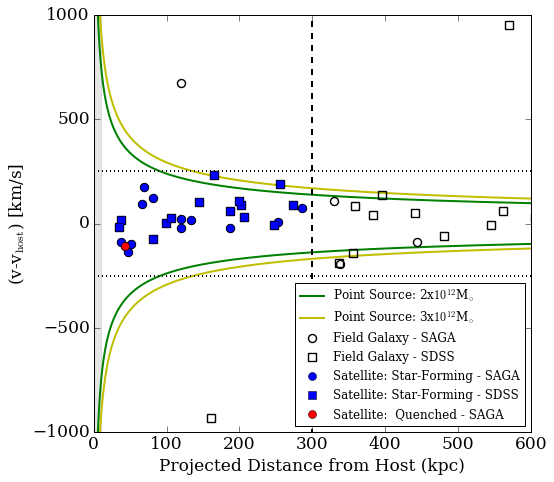

In [21]:

plt.plot(r,vesc2,'g',label = 'Point Source: 2x$10^{12}$M$_{\circ}$')
plt.plot(r,-1.*vesc2,'g')
plt.plot(r,vesc3p,'y',label = 'Point Source: 3x$10^{12}$M$_{\circ}$')
plt.plot(r,-1.*vesc3p,'y')



# FIND OBJECTS BELOW LIMIT
rmag = allspec['r'] - allspec['EXTINCTION_R']
dmod = 5.*np.log10(1e6 * allspec['HOST_DIST']) - 5.
Mr = rmag - dmod
mlim = Mr < -12.3

msdss = np.array(['SDSS' in x for x in allspec['SPEC_REPEAT']])

m1=8

plt.plot(allspec['RHOST_KPC'][msk&mlim&~msdss],v_diff[msk&mlim&~msdss],'ko',markerfacecolor='none',label='Field Galaxy - SAGA',markersize=m1,markeredgewidth=1.4)
plt.plot(allspec['RHOST_KPC'][msk&mlim&msdss],v_diff[msk&mlim&msdss],'ks',markerfacecolor='none',label='Field Galaxy - SDSS',markersize=m1,markeredgewidth=1.4)

plt.plot(allspec['RHOST_KPC'][msk&s&mlim&~msdss],v_diff[msk&s&mlim&~msdss],'bo',label='Satellite: Star-Forming - SAGA',markersize=m1)
plt.plot(allspec['RHOST_KPC'][msk&s&mlim&msdss],v_diff[msk&s&mlim&msdss],'bs',label='Satellite: Star-Forming - SDSS',markersize=m1)
plt.plot(allspec['RHOST_KPC'][msk&prox&s&mlim],v_diff[msk&prox&s&mlim],'ro',label='Satellite:  Quenched - SAGA',markersize=m1)



 
 


print allspec['OBJID'][msk&prox&s]


plt.xlabel('Projected Distance from Host (kpc)')
plt.ylabel('(v-v$_{\mathrm{host}}$) [km/s]')

plt.ylim(-1000,1000)
plt.xlim(0,600)

plt.plot([0,1000],[250,250],'k:')
plt.plot([0,1000],[-250,-250],'k:')
plt.plot([300,300],[-1500,1500],'k--')

#
plt.axvspan(0, 10,alpha=0.1,color='k')
            
plt.legend(fontsize=12,loc=4,frameon=True,numpoints = 1)
plt.tight_layout()
plt.savefig('fig_sat_v.pdf')
plt.show()


       OBJID       
-------------------
1237666408439677694
1237679005021831801


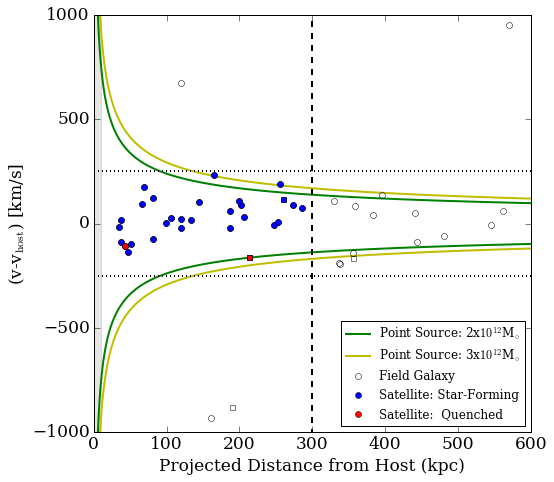

In [16]:
# MAKE THE PLOT
plt.plot(r,vesc2,'g',label = 'Point Source: 2x$10^{12}$M$_{\circ}$')
plt.plot(r,-1.*vesc2,'g')
plt.plot(r,vesc3p,'y',label = 'Point Source: 3x$10^{12}$M$_{\circ}$')
plt.plot(r,-1.*vesc3p,'y')



# FIND OBJECTS BELOW LIMIT
rmag = allspec['r'] - allspec['EXTINCTION_R']
dmod = 5.*np.log10(1e6 * allspec['HOST_DIST']) - 5.
Mr = rmag - dmod
mlim = Mr < -12.3

plt.plot(allspec['RHOST_KPC'][msk&mlim],v_diff[msk&mlim],'ko',markerfacecolor='none',label='Field Galaxy')
plt.plot(allspec['RHOST_KPC'][msk&s&mlim],v_diff[msk&s&mlim],'bo',label='Satellite: Star-Forming')

plt.plot(allspec['RHOST_KPC'][msk&~mlim],v_diff[msk&~mlim],'ks',markerfacecolor='none',label='_nolabel_',ms=5)
plt.plot(allspec['RHOST_KPC'][msk&s&~mlim],v_diff[msk&s&~mlim],'bs',label='_nolabel_',ms=5)

 
 
plt.plot(allspec['RHOST_KPC'][msk&prox&s&mlim],v_diff[msk&prox&s&mlim],'ro',label='Satellite:  Quenched')
plt.plot(allspec['RHOST_KPC'][msk&prox&s&~mlim],v_diff[msk&prox&s&~mlim],'rs',label='_nolabel_',ms=5)

print allspec['OBJID'][msk&prox&s]


plt.xlabel('Projected Distance from Host (kpc)')
plt.ylabel('(v-v$_{\mathrm{host}}$) [km/s]')

plt.ylim(-1000,1000)
plt.xlim(0,600)

plt.plot([0,1000],[250,250],'k:')
plt.plot([0,1000],[-250,-250],'k:')
plt.plot([300,300],[-1500,1500],'k--')

#
plt.axvspan(0, 10,alpha=0.1,color='k')
            
plt.legend(fontsize=12,loc=4,frameon=True,numpoints = 1)
plt.tight_layout()
#plt.savefig('fig_sat_v.pdf')
plt.show()
